<a href="https://colab.research.google.com/github/galopyz/hprc/blob/main/circadian21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 24hr predictions

Using meta_analysis data with bigger taining data.

1. Batch data.
2. Data_columns - Test_data_columns
3. For bulk data, fill missing data with 0.
4. Add columns to indicate missing genes and fill missing gene with 0.
  - Add data augmentation that does this on training data.
  - For some reason, data augmentation performed worse.
5. Use linear layer for 24hr prediction.
  - Trying on other bulk data.
6. Modified R2 score
5. Gene normalization

TODO:
  - Normalize all the data in the same way.
  - Before normalizign the more_data, take care of data with only zeros for the gene expression.

## Import libraries

In [111]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import tensor
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.augment import *
from miniai.xtras import *

In [112]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/'Colab Notebooks'
# !pip -q install torcheval
# !pip -q install datasets
# path = Path('data/circadian')
path = Path('data')
bulk_path = Path.home()/'Downloads/data'

In [113]:
from torch.nn import init
from functools import partial
from torch.optim import lr_scheduler
from torch import tensor,nn,optim

import fastcore.all as fc

In [114]:
loss_func = F.mse_loss

In [115]:
class TimeLayer(nn.Module):
    def __init__(self, range = 26):
        super().__init__()
        self.range = range

    def forward(self, x):
        # return (F.sigmoid(x) * self.range - (self.range - 24)/2) % 24
        return (F.sigmoid(x) * self.range - (self.range - 24)/2)

In [116]:
from torcheval.metrics import R2Score
# metric = MetricsCB(R2Score=R2Score())
# metric = R2Score()

In [117]:
class TimeR2Score(R2Score):
    def update(self, input, target):
        inp = input.clone()
        for i, (x, y) in enumerate(zip(input, target)):
            min_x = x
            min_diff = torch.inf
            for z in [x-24, x, x+24]:
                if abs(z-y) < min_diff:
                    min_diff = abs(z-y)
                    min_x = z
            inp[i] = min_x
        super().update(inp, target)

In [118]:
metric = MetricsCB(R2Score=TimeR2Score())

## Data

<img src="data/cell_nrm.jpg" alt="Cell normalization" width="400">

In [119]:
def nrm_genes(df):
    """Assuming genes on cols cells on rows."""
    cell_divided = df.div(df.sum(axis=1), axis=0)
    return (cell_divided - cell_divided.mean(axis=0)) / cell_divided.std(axis=0)

In [120]:
bulk = pd.read_csv(path/'sc_RNA_ct.csv', low_memory=False)
bulk = bulk.set_index('Unnamed: 0').T
bulk = nrm_genes(bulk)
bulk

Unnamed: 0,Xkr4,Rp1,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,4732440D04Rik,...,mt-Co2,mt-Atp8,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb
AAACAGCCAGCAATAA.8,-0.049673,-0.04268,-0.124963,-0.489307,-0.363687,-0.633744,-0.048407,-0.626202,-0.174223,-0.312544,...,-0.331006,-0.146142,-0.368729,-0.094769,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,0.000030
AAACGCGCAGTATGTT.8,-0.049673,-0.04268,-0.124963,-0.489307,2.078659,-0.633744,-0.048407,-0.626202,1.304845,-0.312544,...,-0.104301,-0.146142,-0.190708,-0.086019,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.414213
AAAGCGGGTGCATCGG.8,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,0.477558,-0.168903,-0.312544,...,-0.462332,-0.146142,-0.264324,-0.092338,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.414213
AAAGGACGTAAGGTTT.8,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,-0.626202,0.512518,-0.312544,...,0.010841,-0.146142,-0.286073,0.218951,-0.293294,-0.212751,-0.432418,1.039197,-0.118702,-0.041078
AAAGGAGCAACCGCCA.8,-0.049673,-0.04268,-0.124963,-0.489307,1.023501,-0.633744,-0.048407,-0.626202,0.480769,-0.312544,...,-0.462332,-0.146142,-0.107936,-0.140863,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.048753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTCCAAGTCTACTAAG.2,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,-0.626202,-1.031017,-0.312544,...,-0.076857,-0.146142,0.133536,-0.486173,-0.293294,-0.212751,0.315597,-0.324576,-0.118702,0.193742
TACCGTTGTTACGCAA.2,-0.049673,-0.04268,-0.124963,-0.489307,0.426962,-0.633744,-0.048407,-0.626202,-1.031017,3.542551,...,0.499527,-0.146142,-0.220086,0.230510,-0.293294,3.425442,0.189745,-0.324576,-0.118702,0.091455
TCCATCATCAGGTTTA.2,-0.049673,-0.04268,-0.124963,-0.489307,0.745681,1.589905,-0.048407,-0.626202,-1.031017,-0.312544,...,-0.065406,-0.146142,-0.160166,0.105327,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,0.837817
TCGTTAGCAGTAGGAT.2,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,-0.626202,-1.031017,-0.312544,...,2.106065,-0.146142,-0.471852,0.279314,-0.293294,-0.212751,0.564378,-0.324576,-0.118702,-0.414213


In [121]:
bulk.mean(axis=0), bulk.std(axis=0)

(Unnamed: 0
 Xkr4      -9.370579e-16
 Rp1        1.494557e-15
 Sox17      5.149340e-15
 Mrpl15     1.464738e-15
 Lypla1    -6.293459e-15
                ...     
 mt-Nd4l   -1.640594e-14
 mt-Nd4     3.022342e-14
 mt-Nd5     6.536581e-15
 mt-Nd6     1.068012e-15
 mt-Cytb   -3.061406e-14
 Length: 16368, dtype: float64,
 Unnamed: 0
 Xkr4       1.0
 Rp1        1.0
 Sox17      1.0
 Mrpl15     1.0
 Lypla1     1.0
           ... 
 mt-Nd4l    1.0
 mt-Nd4     1.0
 mt-Nd5     1.0
 mt-Nd6     1.0
 mt-Cytb    1.0
 Length: 16368, dtype: float64)

In [122]:
bulk_tz = pd.read_csv(path/'sc_RNA_ZT.csv', low_memory=False).set_index('Unnamed: 0')
bulk_tz

,ZT
Unnamed: 0,
AAACAGCCAGCAATAA-8,ZT18
AAACGCGCAGTATGTT-8,ZT18
AAAGCGGGTGCATCGG-8,ZT18
AAAGGACGTAAGGTTT-8,ZT18
AAAGGAGCAACCGCCA-8,ZT18
...,...
GTCCAAGTCTACTAAG-2,ZT06
TACCGTTGTTACGCAA-2,ZT06
TCCATCATCAGGTTTA-2,ZT06


In [123]:
bulk.index = bulk.index.str.replace('.', '-')
bulk['code'] = bulk_tz
bulk['code'] = bulk.loc[:,'code'].str[-2:].map(float)
bulk

Unnamed: 0,Xkr4,Rp1,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,4732440D04Rik,...,mt-Atp8,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,code
AAACAGCCAGCAATAA-8,-0.049673,-0.04268,-0.124963,-0.489307,-0.363687,-0.633744,-0.048407,-0.626202,-0.174223,-0.312544,...,-0.146142,-0.368729,-0.094769,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,0.000030,18.0
AAACGCGCAGTATGTT-8,-0.049673,-0.04268,-0.124963,-0.489307,2.078659,-0.633744,-0.048407,-0.626202,1.304845,-0.312544,...,-0.146142,-0.190708,-0.086019,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.414213,18.0
AAAGCGGGTGCATCGG-8,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,0.477558,-0.168903,-0.312544,...,-0.146142,-0.264324,-0.092338,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.414213,18.0
AAAGGACGTAAGGTTT-8,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,-0.626202,0.512518,-0.312544,...,-0.146142,-0.286073,0.218951,-0.293294,-0.212751,-0.432418,1.039197,-0.118702,-0.041078,18.0
AAAGGAGCAACCGCCA-8,-0.049673,-0.04268,-0.124963,-0.489307,1.023501,-0.633744,-0.048407,-0.626202,0.480769,-0.312544,...,-0.146142,-0.107936,-0.140863,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.048753,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTCCAAGTCTACTAAG-2,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,-0.626202,-1.031017,-0.312544,...,-0.146142,0.133536,-0.486173,-0.293294,-0.212751,0.315597,-0.324576,-0.118702,0.193742,6.0
TACCGTTGTTACGCAA-2,-0.049673,-0.04268,-0.124963,-0.489307,0.426962,-0.633744,-0.048407,-0.626202,-1.031017,3.542551,...,-0.146142,-0.220086,0.230510,-0.293294,3.425442,0.189745,-0.324576,-0.118702,0.091455,6.0
TCCATCATCAGGTTTA-2,-0.049673,-0.04268,-0.124963,-0.489307,0.745681,1.589905,-0.048407,-0.626202,-1.031017,-0.312544,...,-0.146142,-0.160166,0.105327,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,0.837817,6.0
TCGTTAGCAGTAGGAT-2,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,-0.626202,-1.031017,-0.312544,...,-0.146142,-0.471852,0.279314,-0.293294,-0.212751,0.564378,-0.324576,-0.118702,-0.414213,6.0


### Bulk + scRNA-seq

In [124]:
raw_gro = pd.read_csv(path/'gro.csv', low_memory=False)
raw_gro.drop(columns=['Unnamed: 0'], inplace=True)
raw_gro.rename(columns={'Symbol': 'ID'}, inplace=True)

In [125]:
raw_nascent = pd.read_csv(path/'Nascent.csv', low_memory=False)
raw_nascent.drop(columns=['Unnamed: 0'], inplace=True)

In [126]:
raw_bulk_data = pd.read_csv(path/'RNA.csv', low_memory=False)

In [127]:
bulk_data = nrm_genes(raw_bulk_data.set_index('ID').T)
bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]

In [128]:
gro = nrm_genes(raw_gro.set_index('ID').T)
nascent = nrm_genes(raw_nascent.set_index('ID').T)

bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]
gro['code'] = [1,4,7,10,13,16,19,22]
nascent['code'] = [0,4,8,12,16,20,0,4,8,12,16,20]

In [129]:
bulk_data

ID,2810459M11Rik,Abcb11,Acot7,Ahctf1,Ap2a2,Asb13,Asl,Chka,Clic3,Clpx,...,Ap1s3,Vamp4,Pigm,Pard6g,Gas2,Pot1b,Zfp759,Neo1,Sco1,code
ZT2_1,1.082428,1.717867,-1.003875,-0.669267,0.816101,0.471805,-1.540975,0.119574,-0.233131,0.838950,...,2.747362,-0.460841,1.917347,0.127566,-0.799820,-0.455745,0.146379,-0.576091,-0.564002,2
ZT6_1,0.087753,0.330009,0.187294,-1.181104,-0.846484,-0.303438,-0.654141,-1.137337,-0.525248,-1.029984,...,-0.795557,0.173786,-0.709879,0.108785,0.712511,-1.142857,-1.223899,1.112721,0.012469,6
ZT10_1,-0.816346,-1.057083,0.371357,-0.641244,-1.933474,-1.821166,0.745540,-1.019232,-0.542662,-1.163239,...,0.210171,0.221001,-0.251049,-1.652786,-0.313158,-0.071726,1.834361,-2.024334,-1.792529,10
ZT14_1,-0.720197,-0.938543,1.729306,0.761443,-0.105645,-0.403631,0.799266,-0.165066,-0.295312,-0.428135,...,0.554481,1.596180,0.494570,0.966976,0.040629,-0.017075,-0.643337,1.521204,1.411758,14
ZT18_1,0.209483,-0.409910,0.342193,1.282113,0.381770,0.574437,0.963199,0.562810,0.010501,1.133141,...,-0.413376,-1.200138,0.904244,-0.121357,1.189584,0.706100,0.058198,-0.260754,0.365997,18
ZT22_1,0.964961,0.638207,-0.978263,0.952341,1.044113,1.314212,0.053336,1.354167,0.166896,1.220084,...,0.232522,1.487383,-1.045996,-0.325668,0.554796,-0.962842,-0.270750,0.215825,1.505933,22
ZT2_2,0.989394,1.513236,-1.954013,-1.001980,0.653880,1.008998,-1.513408,0.063987,-0.301113,0.527549,...,-0.975348,0.177286,0.747333,0.032291,-1.560521,-0.145595,-0.202777,-0.988569,-0.277518,2
ZT6_2,-0.459597,-0.288067,-0.071178,-1.267921,-0.483437,-0.590565,-0.910870,-1.159240,-0.525305,-1.141050,...,-0.702303,0.120681,-0.215092,1.631189,1.269801,1.666237,-0.644183,1.237696,1.116562,6
ZT10_2,-2.227564,-1.186357,0.848500,-0.403784,-1.300503,-1.300770,0.118115,-1.101337,-0.492871,-1.113219,...,-0.038684,-0.679336,-0.473697,-0.482347,0.341780,0.661954,0.250987,-0.473569,0.287446,10
ZT14_2,-0.567742,-1.055971,0.951135,0.417576,-0.312159,-0.543626,1.341477,-0.285257,-0.405983,-0.650162,...,0.079044,-1.345802,-0.104850,-0.336308,-1.907668,-1.835495,0.130619,-0.182400,-0.289401,14


We only want the intersection of training and test data.

In [130]:
intersecting_genes = bulk_data.columns.intersection(bulk.columns)
df = bulk.loc[:,intersecting_genes]

## Adding more datasets

See meta_analysis for more data.

In [131]:
path = Path('data/scRNA_datasets')
more_data = pd.read_csv(path/'tpm.by_sample.txt', sep='\t', low_memory=False).dropna(how='any').T.drop(index='Name')
more_data.columns = more_data.loc['Symbol']
more_data = more_data.drop(index='Symbol')
more_data = more_data.astype('float64')

Getting rid of genes that don't express anything.

In [132]:
# Checking which ones are in training data
zero_cols = more_data.loc[:,more_data.sum(axis=0) == 0].columns
len(set(zero_cols).intersection(df.columns))

0

In [133]:
more_data = more_data.drop(zero_cols, axis=1)
more_data

Symbol,Gm14820,Flicr,Gm13449,C79798,Nron,Gm13528,4930527E20Rik,Gm13402,AA645442,Sardhos,...,Eef1akmt4,Il33,Pgam1-ps1,Gm10517,Vmn1r-ps84,Rpsa-ps3,Gm14634,Zkscan7,Agbl1,Gm8902
GSM2046160,0.047856,0.043026,0.013747,0.000000,0.017114,0.184585,0.0,0.000000,0.000000,8.55776,...,4.80793,0.585986,0.043350,0.000000,0.0,0.000000,0.029685,2.69082,0.0,0.000000
GSM2046184,0.000000,0.017274,0.012649,0.000000,0.000000,0.225739,0.0,0.000000,0.084449,4.54988,...,4.70429,0.682593,0.038878,0.000000,0.0,0.017092,0.031688,2.20585,0.0,0.000000
GSM2046157,0.011696,0.012144,0.029259,0.000000,0.000000,0.246204,0.0,0.000000,0.000000,8.24781,...,3.84295,0.521939,0.045233,0.119700,0.0,0.000000,0.000000,2.56285,0.0,0.015267
GSM2046183,0.038796,0.035352,0.012449,0.000000,0.000000,0.207048,0.0,0.000000,0.000000,8.40232,...,4.45069,0.404564,0.017379,0.170666,0.0,0.000000,0.009918,2.47665,0.0,0.000000
GSM2046155,0.000000,0.025837,0.080033,0.000000,0.000000,0.157396,0.0,0.000000,0.619891,11.43590,...,4.87733,0.367240,0.088547,0.134558,0.0,0.000000,0.007446,2.71046,0.0,0.011883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6610738,0.000000,0.035516,0.215311,0.000000,0.000000,0.000000,0.0,0.130749,0.316231,0.00000,...,8.84043,0.794336,0.318900,0.000000,0.0,0.000000,0.023322,1.85593,0.0,0.000000
GSM6610724,0.000000,0.078964,0.200141,0.000000,0.000000,0.806385,0.0,0.000000,0.000000,0.00000,...,8.37920,0.752421,0.165695,0.110278,0.0,0.000000,0.070138,1.70914,0.0,0.000000
GSM6610752,0.000000,0.043414,0.228735,0.000000,0.000000,0.447329,0.0,0.000000,0.405717,0.00000,...,8.78542,0.796097,0.265712,0.000000,0.0,0.000000,0.054193,2.71010,0.0,0.000000
GSM6610726,0.016459,0.043835,0.284069,0.028452,0.000000,1.184650,0.0,0.000000,0.829571,1.58835,...,7.12422,0.715682,0.034111,0.276602,0.0,0.000000,0.047538,1.66776,0.0,0.000000


In [134]:
more_data = nrm_genes(more_data)
more_data.mean(axis=0), more_data.std(axis=0)

(Symbol
 Gm14820    -2.856659e-16
 Flicr       1.852989e-16
 Gm13449     3.932378e-16
 C79798     -6.583086e-16
 Nron       -1.064892e-16
                 ...     
 Rpsa-ps3    3.448681e-16
 Gm14634    -7.021958e-16
 Zkscan7    -2.554083e-15
 Agbl1       2.256913e-16
 Gm8902     -2.688948e-16
 Length: 32904, dtype: float64,
 Symbol
 Gm14820     1.0
 Flicr       1.0
 Gm13449     1.0
 C79798      1.0
 Nron        1.0
            ... 
 Rpsa-ps3    1.0
 Gm14634     1.0
 Zkscan7     1.0
 Agbl1       1.0
 Gm8902      1.0
 Length: 32904, dtype: float64)

In [135]:
meta_data = pd.read_csv(path/'sample_metadata.txt', sep='\t', index_col='sample', low_memory=False)
more_data['code'] = meta_data['time']
more_data

Symbol,Gm14820,Flicr,Gm13449,C79798,Nron,Gm13528,4930527E20Rik,Gm13402,AA645442,Sardhos,...,Il33,Pgam1-ps1,Gm10517,Vmn1r-ps84,Rpsa-ps3,Gm14634,Zkscan7,Agbl1,Gm8902,code
GSM2046160,0.259269,-0.157117,-0.246090,-0.136791,1.989747,-0.360068,-0.058182,-0.171698,-0.470116,2.019621,...,-0.495987,0.179397,-0.319751,-0.045089,-0.227785,-0.340332,0.049125,-0.108363,-0.133167,22.0
GSM2046184,-0.058396,-0.269264,-0.248887,-0.136791,-0.098070,-0.307829,-0.058182,-0.171698,-0.410231,0.846156,...,-0.304115,0.118501,-0.319751,-0.045089,0.115119,-0.308742,-0.296044,-0.108363,-0.133167,22.0
GSM2046157,0.019232,-0.291584,-0.206713,-0.136791,-0.098070,-0.281764,-0.058182,-0.171698,-0.470116,1.928629,...,-0.623569,0.204906,0.920292,-0.045089,-0.227785,-0.810639,-0.042041,-0.108363,0.282452,10.0
GSM2046183,0.198919,-0.190655,-0.249412,-0.136791,-0.098070,-0.331724,-0.058182,-0.171698,-0.470116,1.972117,...,-0.857706,-0.173566,1.447035,-0.045089,-0.227785,-0.653634,-0.104544,-0.108363,-0.133167,18.0
GSM2046155,-0.058396,-0.231989,-0.077843,-0.136791,-0.098070,-0.394689,-0.058182,-0.171698,-0.030527,2.861126,...,-0.931528,0.792993,1.073994,-0.045089,-0.227785,-0.692702,0.062562,-0.108363,0.190277,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6610738,-0.058396,-0.188282,0.271110,-0.136791,-0.098070,-0.594739,-0.058182,5.690522,-0.243579,-0.485181,...,-0.065659,3.965212,-0.319751,-0.045089,-0.227785,-0.437478,-0.531234,-0.108363,-0.133167,13.5
GSM6610724,-0.058396,0.003074,0.232662,-0.136791,-0.098070,0.441533,-0.058182,-0.171698,-0.470116,-0.485181,...,-0.148572,1.865558,0.835159,-0.045089,-0.227785,0.312584,-0.635527,-0.108363,-0.133167,7.5
GSM6610752,-0.058396,-0.154137,0.303737,-0.136791,-0.098070,-0.022147,-0.058182,-0.171698,-0.180364,-0.485181,...,-0.067015,3.224430,-0.319751,-0.045089,-0.227785,0.053816,0.075979,-0.108363,-0.133167,19.5
GSM6610726,0.051729,-0.152073,0.446019,2.480244,-0.098070,0.923370,-0.058182,-0.171698,0.123017,-0.016574,...,-0.226513,0.057596,2.568907,-0.045089,-0.227785,-0.051476,-0.668614,-0.108363,-0.133167,7.5


In `more_data`, there are duplicate genes, such as '4930594M22Rik'.

In [136]:
more_data.columns.duplicated().sum()

27

In [137]:
more_data = more_data.loc[:, ~more_data.columns.duplicated(keep='first')]

In [138]:
more_data.columns.duplicated().sum()

0

## Changing the testing bulk data

We also want the shape of test data to match the shape of our train data.

In [139]:
len(intersecting_genes)

9335

In [140]:
bulk.loc[:,intersecting_genes].shape

(26068, 9335)

In [141]:
def make_df2(ds):
    """Assuming the dataset includes all the genes of intersecting_genes"""
    return ds.reindex(columns=intersecting_genes, fill_value=0)

In [142]:
nascent_df = make_df2(nascent)
gro_df = make_df2(gro)
rna_df = make_df2(bulk_data)
more_df = make_df2(more_data)

## Using Pytorch

In [143]:
t_dep = tensor(df['code'], dtype=torch.float)
indep_cols = list(df.columns)[:-1]
t_indep = tensor(df[indep_cols].values, dtype=torch.float32)

/tmp/ipykernel_12273/705046130.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_dep = tensor(df['code'], dtype=torch.float)


In [144]:
# from fastai.data.transforms import RandomSplitter
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = list(torch.randperm(len(o)).numpy())
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
trn_split,val_split=RandomSplitter(seed=42)(df)

In [145]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

In [146]:
trn_dep.unsqueeze_(-1), val_dep.unsqueeze_(-1)
trn_dep.shape, val_dep.shape

(torch.Size([20855, 1]), torch.Size([5213, 1]))

### DataLoaders

Pretty much the same as the previous approach with bulk data as the test data.

In [147]:
bs = 128
n_workers = 2

trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=bs, shuffle=True, num_workers=n_workers)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=bs, shuffle=False, num_workers=n_workers)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([128, 9334]), torch.Size([128, 1]))

In [148]:
def make_dl(df):
    tst_dep = tensor(df['code'], dtype=torch.float)
    tst_indep_cols = list(df.columns)[:-1]
    tst_indep = tensor(df[tst_indep_cols].values, dtype=torch.float32)
    tst_dep.unsqueeze_(-1)
    return DataLoader(list(zip(tst_indep, tst_dep)), shuffle=False, num_workers=n_workers)

In [149]:
nascent_dl = make_dl(nascent_df)
gro_dl = make_dl(gro_df)
rna_dl = make_dl(rna_df)
more_dl = make_dl(more_df)
tst_dls = {'nascent':nascent_dl, 'gro':gro_dl, 'rna':rna_dl, 'more': more_dl}

/tmp/ipykernel_12273/2507783698.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(df['code'], dtype=torch.float)
/tmp/ipykernel_12273/2507783698.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(df['code'], dtype=torch.float)
/tmp/ipykernel_12273/2507783698.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(df['code'], dtype=torch.float)
/tmp/ipykernel_12273/2507783698.py:2: Fu

Changing the metric to R2Score.

In [150]:
from torcheval.metrics import R2Score
metrics = MetricsCB(TimeR2Score=TimeR2Score())
metric_fn = TimeR2Score
# metrics = MetricsCB(R2Score=R2Score())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

## Training

In [151]:
def get_model():
    return nn.Sequential(*[nn.Linear(len(indep_cols), 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 1), nn.Flatten(), TimeLayer()])

Change the shape of the inputs to match the shape of targets.

In [152]:
nn.Linear(len(indep_cols), 1)(xb).shape

torch.Size([128, 1])

In [153]:
get_model()(xb).shape

torch.Size([128, 1])

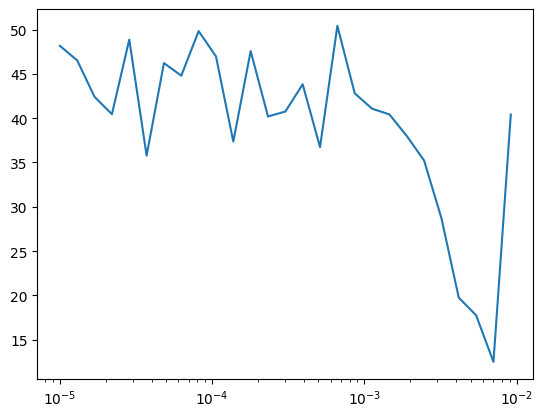

In [154]:
TrainLearner(get_model(), dls, loss_func=loss_func, cbs=cbs).lr_find()

TimeR2Score,loss,epoch,train,time
0.762,10.823,0,True,00:01
0.856,6.509,0,False,00:00
0.953,2.067,1,True,00:01
0.865,6.126,1,False,00:00


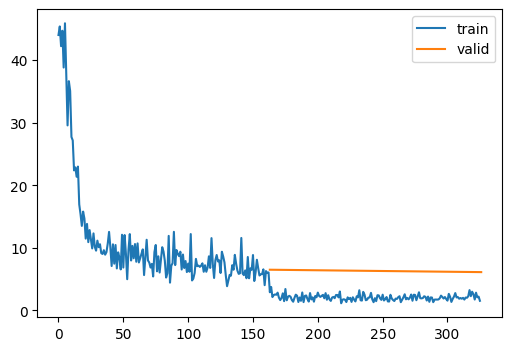

In [155]:
lr, epochs = 1e-3, 2
xtra = [get_sched(epochs, lr, dls)]
learn = TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs)
learn.fit(epochs)

## Ensemble

In [156]:
from functools import partial

In [157]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_input, self.all_preds, self.all_targs = [], [], []

    def after_batch(self, learn):
        self.all_input.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

    def after_fit(self, learn):
        self.all_input, self.all_preds, self.all_targs = map(torch.cat, [self.all_input, self.all_preds, self.all_targs])

In [158]:
def ensemble_model(nlearn, get_model = get_model, tst_dls=tst_dls, epochs=5, lr=.03, loss_func=loss_func, cbs=cbs, opt_func=optim.SGD, metric_fn=metric_fn):
    learners = [TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs, opt_func=opt_func) for _ in range(nlearn)]
    print('Training models')
    for learn in learners:
        learn.fit(epochs)
    cps = [CapturePreds() for _ in range(nlearn)]
    print('Making inference on test data')
    for dl_name, tst_dl in tst_dls.items():
        for learn, cp in zip(learners, cps):
            learn.dls = DataLoaders((), tst_dl)
            learn.fit(1, train=False, cbs=cp)
        ap = torch.stack([cp.all_preds for cp in cps]).mean(0)
        metric = metric_fn()
        metric.update(ap, cps[0].all_targs)
        print(f'Inference on {dl_name}')
        print('\t\tpreds, targs')
        print(torch.concat([ap, cps[0].all_targs], dim=1))
        print('result: ', metric.compute())

In [159]:
nlearn = 2

Training models


TimeR2Score,loss,epoch,train,time
0.758,10.967,0,True,00:01
0.836,7.441,0,False,00:00
0.953,2.105,1,True,00:01
0.863,6.187,1,False,00:00


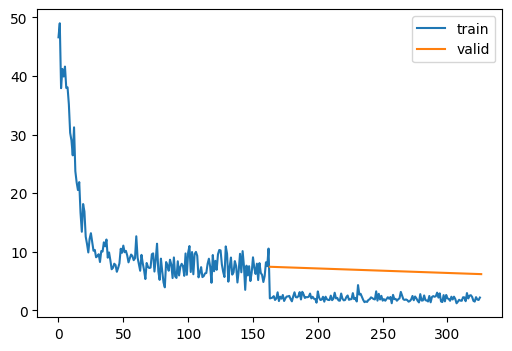

TimeR2Score,loss,epoch,train,time
0.750,11.260,0,True,00:01
0.849,6.758,0,False,00:00
0.951,2.173,1,True,00:01
0.861,6.348,1,False,00:00


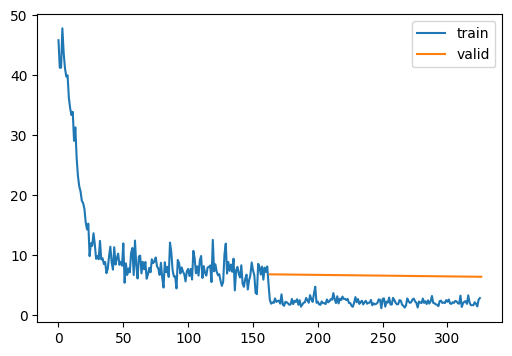

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.292,62.790,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.452,61.259,0,False,00:00


Inference on nascent
		preds, targs
tensor([[19.2249,  0.0000],
        [ 2.5159,  4.0000],
        [ 9.9577,  8.0000],
        [ 4.6709, 12.0000],
        [11.4498, 16.0000],
        [24.1204, 20.0000],
        [ 1.5879,  0.0000],
        [-0.4832,  4.0000],
        [20.9573,  8.0000],
        [ 9.6849, 12.0000],
        [23.4249, 16.0000],
        [24.7769, 20.0000]])
result:  tensor(0.3784)


TimeR2Score,loss,epoch,train,time
0.576,30.199,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.571,36.141,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 3.7052,  1.0000],
        [ 3.6259,  4.0000],
        [ 4.3166,  7.0000],
        [ 9.0562, 10.0000],
        [16.6952, 13.0000],
        [ 1.8281, 16.0000],
        [24.2131, 19.0000],
        [24.2203, 22.0000]])
result:  tensor(0.5823)


TimeR2Score,loss,epoch,train,time
0.630,34.303,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.501,34.379,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 9.1835,  2.0000],
        [ 4.7290,  6.0000],
        [ 8.7908, 10.0000],
        [14.6666, 14.0000],
        [24.3080, 18.0000],
        [24.2432, 22.0000],
        [ 3.2534,  2.0000],
        [ 9.0388,  6.0000],
        [ 9.9468, 10.0000],
        [10.7773, 14.0000],
        [11.1704, 18.0000],
        [ 6.4824, 22.0000]])
result:  tensor(0.5719)


TimeR2Score,loss,epoch,train,time
0.691,153.908,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.700,151.495,0,False,00:01


Inference on more
		preds, targs
tensor([[ 5.5455, 22.0000],
        [ 5.0622, 22.0000],
        [ 8.1108, 10.0000],
        [15.3968, 18.0000],
        [10.3716,  2.0000],
        [16.8829, 18.0000],
        [10.2662, 14.0000],
        [ 1.9021,  6.0000],
        [ 2.1422,  6.0000],
        [13.2920, 14.0000],
        [ 7.1810, 10.0000],
        [13.6086,  2.0000],
        [22.0254, 24.0000],
        [22.1361, 21.0000],
        [ 8.8937, 33.0000],
        ...,
        [16.7429,  7.5000],
        [22.5537,  1.5000],
        [17.3511, 16.5000],
        [24.0260,  4.5000],
        [22.3803, 22.5000],
        [20.0405, 16.5000],
        [23.2246,  1.5000],
        [15.4351, 10.5000],
        [21.4220, 16.5000],
        [24.4919,  1.5000],
        [14.8310, 13.5000],
        [13.2351,  7.5000],
        [23.8816, 19.5000],
        [11.5293,  7.5000],
        [17.0117, 13.5000]])
result:  tensor(0.6961)


In [160]:
ensemble_model(nlearn, epochs=2, cbs=cbs, lr=1e-3, loss_func=loss_func)

In [161]:
def init_params(m, leaky=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)): init.kaiming_normal_(m.weight, a=leaky)

## Batchnorm

In [162]:
def get_model():
    return nn.Sequential(*[
    nn.Linear(len(indep_cols), 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 1),
    nn.BatchNorm1d(1),
    TimeLayer()
]).apply(init_params)

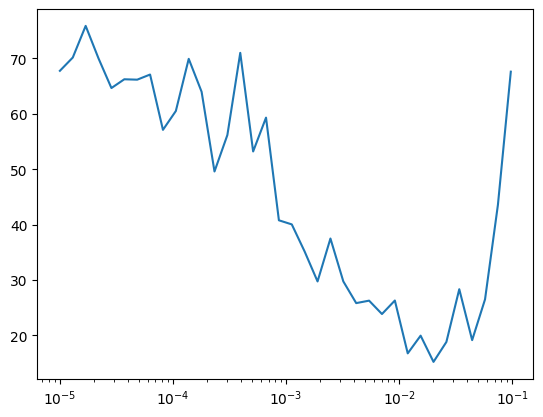

In [163]:
TrainLearner(get_model(), dls, loss_func, cbs=DeviceCB()).lr_find()

Training models


TimeR2Score,loss,epoch,train,time
0.770,11.016,0,True,00:01
0.831,8.327,0,False,00:00
0.874,5.782,1,True,00:01
0.845,7.157,1,False,00:00
0.926,3.305,2,True,00:01
0.878,5.648,2,False,00:00
0.959,1.842,3,True,00:01
0.887,5.281,3,False,00:00


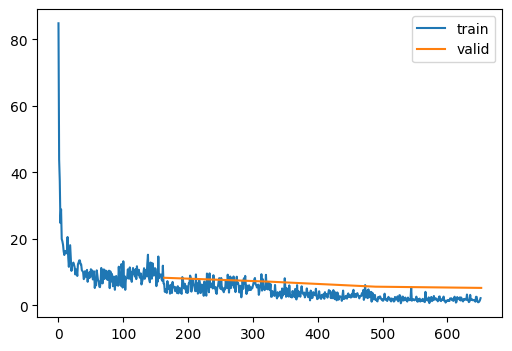

TimeR2Score,loss,epoch,train,time
0.774,10.685,0,True,00:01
0.797,10.272,0,False,00:00
0.871,5.875,1,True,00:01
0.865,6.398,1,False,00:00
0.925,3.347,2,True,00:01
0.880,5.651,2,False,00:00
0.961,1.754,3,True,00:01
0.886,5.303,3,False,00:00


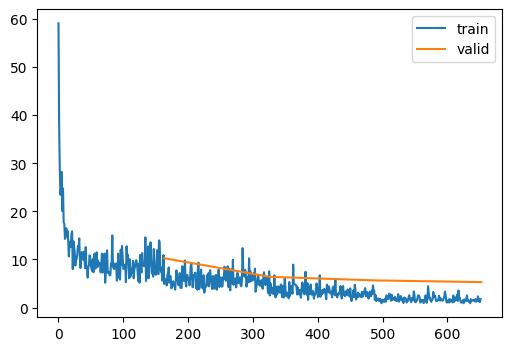

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.610,31.420,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.678,28.698,0,False,00:00


Inference on nascent
		preds, targs
tensor([[15.3620,  0.0000],
        [ 3.3548,  4.0000],
        [ 9.4621,  8.0000],
        [ 6.0242, 12.0000],
        [13.1758, 16.0000],
        [21.9137, 20.0000],
        [ 1.0895,  0.0000],
        [ 1.9683,  4.0000],
        [12.4448,  8.0000],
        [ 8.5973, 12.0000],
        [21.2045, 16.0000],
        [22.7759, 20.0000]])
result:  tensor(0.6501)


TimeR2Score,loss,epoch,train,time
0.417,28.348,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.670,15.602,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 2.6394,  1.0000],
        [ 9.1406,  4.0000],
        [ 6.4031,  7.0000],
        [ 9.2946, 10.0000],
        [13.6586, 13.0000],
        [ 4.7005, 16.0000],
        [21.1175, 19.0000],
        [22.7053, 22.0000]])
result:  tensor(0.5686)


TimeR2Score,loss,epoch,train,time
0.434,56.532,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.299,42.828,0,False,00:00


Inference on rna
		preds, targs
tensor([[14.3287,  2.0000],
        [ 4.9436,  6.0000],
        [ 9.4034, 10.0000],
        [15.2720, 14.0000],
        [23.6022, 18.0000],
        [22.0223, 22.0000],
        [ 3.3467,  2.0000],
        [ 8.3943,  6.0000],
        [10.2676, 10.0000],
        [ 9.8389, 14.0000],
        [ 6.7334, 18.0000],
        [ 6.2344, 22.0000]])
result:  tensor(0.3029)


TimeR2Score,loss,epoch,train,time
0.683,143.257,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.688,142.907,0,False,00:01


Inference on more
		preds, targs
tensor([[ 4.8832, 22.0000],
        [ 5.7908, 22.0000],
        [ 8.4691, 10.0000],
        [ 9.9628, 18.0000],
        [ 8.7620,  2.0000],
        [ 9.8902, 18.0000],
        [ 9.6659, 14.0000],
        [ 4.1077,  6.0000],
        [ 4.0248,  6.0000],
        [ 9.8523, 14.0000],
        [ 8.4419, 10.0000],
        [ 8.4014,  2.0000],
        [20.6845, 24.0000],
        [20.2946, 21.0000],
        [ 7.0783, 33.0000],
        ...,
        [18.9130,  7.5000],
        [21.9198,  1.5000],
        [15.9277, 16.5000],
        [23.4755,  4.5000],
        [20.8205, 22.5000],
        [17.4939, 16.5000],
        [23.0384,  1.5000],
        [13.5011, 10.5000],
        [19.9758, 16.5000],
        [23.5330,  1.5000],
        [15.0407, 13.5000],
        [19.3886,  7.5000],
        [22.2014, 19.5000],
        [15.6676,  7.5000],
        [16.8194, 13.5000]])
result:  tensor(0.6851)


In [164]:
lr, epochs = .2, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.782,10.252,0,True,00:01
0.835,7.480,0,False,00:00
0.886,5.187,1,True,00:01
0.878,6.157,1,False,00:00
0.946,2.441,2,True,00:01
0.888,5.161,2,False,00:00
0.969,1.369,3,True,00:01
0.892,5.052,3,False,00:00


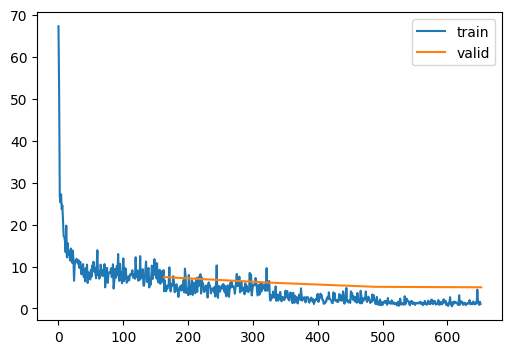

TimeR2Score,loss,epoch,train,time
0.778,10.462,0,True,00:01
0.839,7.520,0,False,00:00
0.889,5.039,1,True,00:01
0.869,5.976,1,False,00:00
0.945,2.434,2,True,00:01
0.882,5.578,2,False,00:00
0.968,1.415,3,True,00:01
0.885,5.341,3,False,00:00


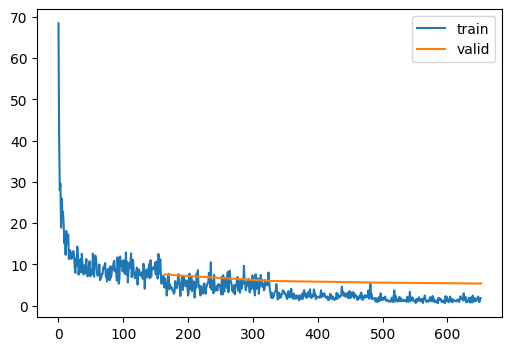

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.584,23.237,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.584,27.821,0,False,00:00


Inference on nascent
		preds, targs
tensor([[13.5311,  0.0000],
        [ 3.4729,  4.0000],
        [ 9.5287,  8.0000],
        [ 6.0627, 12.0000],
        [13.5172, 16.0000],
        [21.6709, 20.0000],
        [ 0.9358,  0.0000],
        [ 1.6878,  4.0000],
        [12.0686,  8.0000],
        [ 8.8775, 12.0000],
        [21.7656, 16.0000],
        [22.4613, 20.0000]])
result:  tensor(0.5924)


TimeR2Score,loss,epoch,train,time
0.674,15.414,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.748,11.887,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 2.3391,  1.0000],
        [ 8.2144,  4.0000],
        [ 5.6811,  7.0000],
        [ 9.3597, 10.0000],
        [12.6406, 13.0000],
        [ 6.9478, 16.0000],
        [20.6756, 19.0000],
        [22.9737, 22.0000]])
result:  tensor(0.7155)


TimeR2Score,loss,epoch,train,time
0.557,37.191,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.364,42.896,0,False,00:00


Inference on rna
		preds, targs
tensor([[10.3581,  2.0000],
        [ 5.7802,  6.0000],
        [ 9.5215, 10.0000],
        [14.5673, 14.0000],
        [23.4458, 18.0000],
        [21.7167, 22.0000],
        [ 1.8601,  2.0000],
        [ 8.0021,  6.0000],
        [10.7472, 10.0000],
        [10.3277, 14.0000],
        [ 7.8041, 18.0000],
        [ 6.2866, 22.0000]])
result:  tensor(0.4806)


TimeR2Score,loss,epoch,train,time
0.693,142.790,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.685,144.149,0,False,00:01


Inference on more
		preds, targs
tensor([[ 5.3517, 22.0000],
        [ 5.4022, 22.0000],
        [ 8.6886, 10.0000],
        [10.6201, 18.0000],
        [ 9.2317,  2.0000],
        [10.5698, 18.0000],
        [ 9.9913, 14.0000],
        [ 3.7091,  6.0000],
        [ 3.8653,  6.0000],
        [10.2746, 14.0000],
        [ 8.2336, 10.0000],
        [ 9.1384,  2.0000],
        [21.0290, 24.0000],
        [20.4614, 21.0000],
        [ 7.7520, 33.0000],
        ...,
        [17.6029,  7.5000],
        [21.9621,  1.5000],
        [16.4781, 16.5000],
        [23.6743,  4.5000],
        [21.0220, 22.5000],
        [17.5429, 16.5000],
        [23.0836,  1.5000],
        [13.5091, 10.5000],
        [19.6501, 16.5000],
        [23.7866,  1.5000],
        [14.4966, 13.5000],
        [18.2006,  7.5000],
        [22.5051, 19.5000],
        [13.6040,  7.5000],
        [15.8330, 13.5000]])
result:  tensor(0.6884)


In [165]:
lr, epochs = .1, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.777,10.516,0,True,00:01
0.805,10.335,0,False,00:00
0.851,6.842,1,True,00:01
0.866,6.125,1,False,00:00
0.899,4.587,2,True,00:01
0.876,5.692,2,False,00:00
0.938,2.798,3,True,00:01
0.885,5.309,3,False,00:00
0.964,1.606,4,True,00:01
0.893,4.901,4,False,00:00


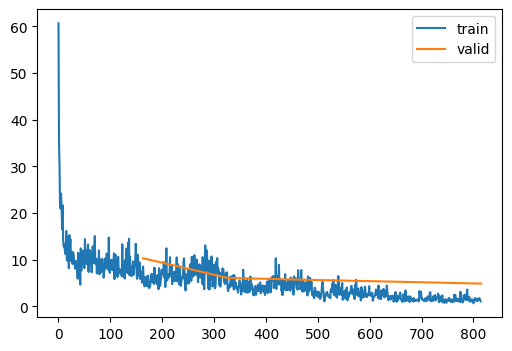

TimeR2Score,loss,epoch,train,time
0.773,10.725,0,True,00:01
0.827,7.983,0,False,00:00
0.857,6.636,1,True,00:01
0.836,7.433,1,False,00:00
0.900,4.512,2,True,00:01
0.866,6.393,2,False,00:00
0.938,2.775,3,True,00:01
0.881,5.485,3,False,00:00
0.965,1.545,4,True,00:01
0.888,5.170,4,False,00:00


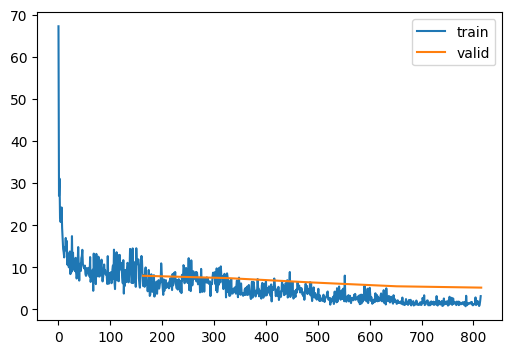

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.633,17.132,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.693,39.656,0,False,00:00


Inference on nascent
		preds, targs
tensor([[13.4042,  0.0000],
        [ 2.9866,  4.0000],
        [ 9.0967,  8.0000],
        [ 5.9202, 12.0000],
        [11.4620, 16.0000],
        [21.2439, 20.0000],
        [ 1.3440,  0.0000],
        [ 1.8195,  4.0000],
        [13.6683,  8.0000],
        [ 8.3031, 12.0000],
        [19.8520, 16.0000],
        [22.2361, 20.0000]])
result:  tensor(0.5611)


TimeR2Score,loss,epoch,train,time
0.620,17.956,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.642,16.905,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 4.9909,  1.0000],
        [11.0958,  4.0000],
        [ 5.6133,  7.0000],
        [ 9.2589, 10.0000],
        [13.4234, 13.0000],
        [ 8.3146, 16.0000],
        [20.2724, 19.0000],
        [22.6278, 22.0000]])
result:  tensor(0.6561)


TimeR2Score,loss,epoch,train,time
0.344,46.272,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.379,32.321,0,False,00:00


Inference on rna
		preds, targs
tensor([[13.5897,  2.0000],
        [ 5.3830,  6.0000],
        [ 9.6188, 10.0000],
        [15.3399, 14.0000],
        [22.9929, 18.0000],
        [20.9813, 22.0000],
        [ 1.5930,  2.0000],
        [ 8.1299,  6.0000],
        [10.2189, 10.0000],
        [10.4042, 14.0000],
        [ 7.1830, 18.0000],
        [ 9.2924, 22.0000]])
result:  tensor(0.2414)


TimeR2Score,loss,epoch,train,time
0.676,143.772,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.687,142.137,0,False,00:01


Inference on more
		preds, targs
tensor([[ 5.5808, 22.0000],
        [ 6.1243, 22.0000],
        [ 8.4140, 10.0000],
        [11.3691, 18.0000],
        [10.6286,  2.0000],
        [11.3836, 18.0000],
        [10.0225, 14.0000],
        [ 3.8225,  6.0000],
        [ 3.7184,  6.0000],
        [10.1750, 14.0000],
        [ 8.3022, 10.0000],
        [10.2645,  2.0000],
        [20.5256, 24.0000],
        [20.4717, 21.0000],
        [ 8.0904, 33.0000],
        ...,
        [17.5685,  7.5000],
        [21.8089,  1.5000],
        [16.2196, 16.5000],
        [23.6125,  4.5000],
        [20.8393, 22.5000],
        [17.4118, 16.5000],
        [22.8282,  1.5000],
        [13.7896, 10.5000],
        [19.7851, 16.5000],
        [23.5764,  1.5000],
        [14.4094, 13.5000],
        [18.7802,  7.5000],
        [22.0436, 19.5000],
        [12.7400,  7.5000],
        [15.9568, 13.5000]])
result:  tensor(0.6825)


In [166]:
lr, epochs = .3, 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.778,10.425,0,True,00:01
0.854,6.708,0,False,00:00
0.882,5.406,1,True,00:01
0.870,6.281,1,False,00:00
0.929,3.193,2,True,00:01
0.869,6.172,2,False,00:00
0.955,2.007,3,True,00:01
0.895,4.909,3,False,00:00
0.971,1.275,4,True,00:01
0.896,4.804,4,False,00:00


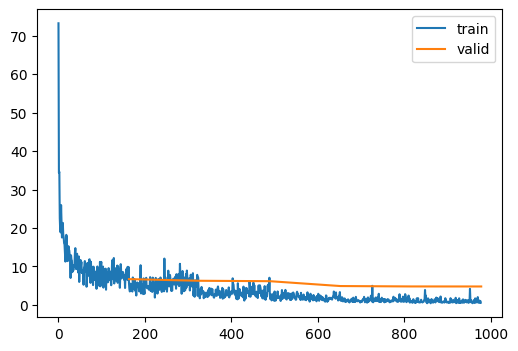

TimeR2Score,loss,epoch,train,time
0.778,10.496,0,True,00:01
0.851,6.682,0,False,00:00
0.882,5.419,1,True,00:01
0.855,6.696,1,False,00:00
0.927,3.268,2,True,00:01
0.864,6.617,2,False,00:00
0.955,1.980,3,True,00:01
0.890,5.060,3,False,00:00
0.972,1.247,4,True,00:01
0.898,4.727,4,False,00:00


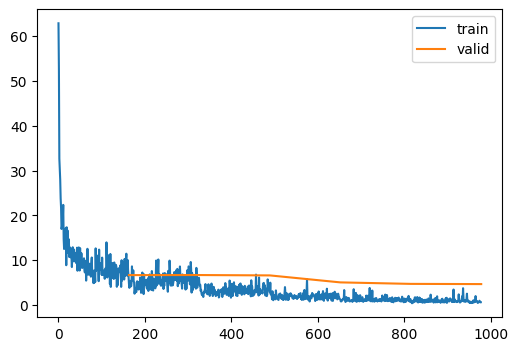

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.653,30.264,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.682,33.304,0,False,00:00


Inference on nascent
		preds, targs
tensor([[16.0643,  0.0000],
        [ 4.3661,  4.0000],
        [ 8.9190,  8.0000],
        [ 6.5684, 12.0000],
        [11.7549, 16.0000],
        [21.6964, 20.0000],
        [ 0.9285,  0.0000],
        [ 2.3394,  4.0000],
        [13.2769,  8.0000],
        [ 9.1888, 12.0000],
        [20.5335, 16.0000],
        [22.9453, 20.0000]])
result:  tensor(0.6733)


TimeR2Score,loss,epoch,train,time
0.706,13.889,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.844,7.380,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 2.6241,  1.0000],
        [ 7.2638,  4.0000],
        [ 6.2155,  7.0000],
        [ 9.4172, 10.0000],
        [13.0717, 13.0000],
        [ 8.9579, 16.0000],
        [21.1072, 19.0000],
        [23.1572, 22.0000]])
result:  tensor(0.8158)


TimeR2Score,loss,epoch,train,time
0.545,46.411,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.357,34.772,0,False,00:00


Inference on rna
		preds, targs
tensor([[11.7160,  2.0000],
        [ 6.0308,  6.0000],
        [ 9.5971, 10.0000],
        [15.0458, 14.0000],
        [23.5720, 18.0000],
        [21.6974, 22.0000],
        [ 1.8700,  2.0000],
        [ 7.8866,  6.0000],
        [10.8767, 10.0000],
        [10.6843, 14.0000],
        [ 6.8459, 18.0000],
        [ 8.1357, 22.0000]])
result:  tensor(0.3406)


TimeR2Score,loss,epoch,train,time
0.683,138.784,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.702,137.880,0,False,00:01


Inference on more
		preds, targs
tensor([[ 5.6992, 22.0000],
        [ 6.3776, 22.0000],
        [ 9.0049, 10.0000],
        [11.2993, 18.0000],
        [10.5129,  2.0000],
        [11.3161, 18.0000],
        [10.4159, 14.0000],
        [ 4.1209,  6.0000],
        [ 4.4901,  6.0000],
        [10.7635, 14.0000],
        [ 8.7868, 10.0000],
        [10.1053,  2.0000],
        [20.3516, 24.0000],
        [20.1734, 21.0000],
        [ 7.5981, 33.0000],
        ...,
        [17.7108,  7.5000],
        [21.5591,  1.5000],
        [16.1124, 16.5000],
        [23.6043,  4.5000],
        [20.6143, 22.5000],
        [17.3593, 16.5000],
        [22.7157,  1.5000],
        [13.8172, 10.5000],
        [19.5886, 16.5000],
        [23.6047,  1.5000],
        [14.6677, 13.5000],
        [17.5155,  7.5000],
        [22.1124, 19.5000],
        [13.2296,  7.5000],
        [15.9491, 13.5000]])
result:  tensor(0.6931)


In [167]:
lr, epochs = .1, 6
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [168]:
torch.set_printoptions(edgeitems=15, linewidth=100)

Training models


TimeR2Score,loss,epoch,train,time
0.775,10.516,0,True,00:01
0.852,6.641,0,False,00:00


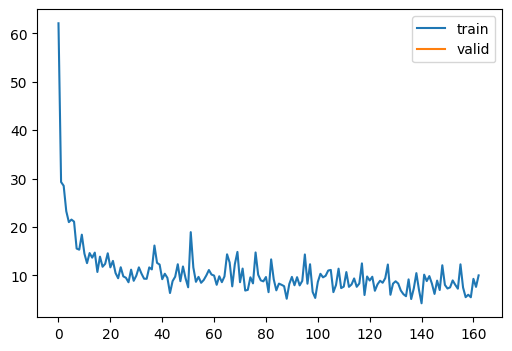

TimeR2Score,loss,epoch,train,time
0.776,10.526,0,True,00:01
0.850,6.676,0,False,00:00


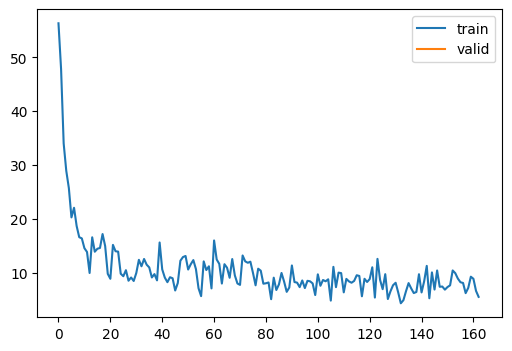

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.611,42.620,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.593,37.717,0,False,00:00


Inference on nascent
		preds, targs
tensor([[17.3946,  0.0000],
        [ 2.3097,  4.0000],
        [11.9597,  8.0000],
        [ 4.8910, 12.0000],
        [12.3997, 16.0000],
        [22.1172, 20.0000],
        [ 1.2888,  0.0000],
        [ 0.2216,  4.0000],
        [13.3723,  8.0000],
        [ 8.2515, 12.0000],
        [20.7515, 16.0000],
        [22.6173, 20.0000]])
result:  tensor(0.6100)


TimeR2Score,loss,epoch,train,time
0.519,28.782,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.603,18.763,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 7.0871,  1.0000],
        [ 4.9071,  4.0000],
        [ 7.1328,  7.0000],
        [ 8.9602, 10.0000],
        [13.2867, 13.0000],
        [ 4.2882, 16.0000],
        [22.1454, 19.0000],
        [21.1487, 22.0000]])
result:  tensor(0.5057)


TimeR2Score,loss,epoch,train,time
0.313,34.429,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.700,14.007,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 7.0330,  2.0000],
        [ 4.2194,  6.0000],
        [ 9.8753, 10.0000],
        [14.0363, 14.0000],
        [24.0168, 18.0000],
        [22.2365, 22.0000],
        [ 2.6534,  2.0000],
        [ 8.8297,  6.0000],
        [11.5204, 10.0000],
        [10.8922, 14.0000],
        [10.5999, 18.0000],
        [11.1773, 22.0000]])
result:  tensor(0.5409)


TimeR2Score,loss,epoch,train,time
0.659,147.087,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.688,137.166,0,False,00:01


Inference on more
		preds, targs
tensor([[ 5.6828, 22.0000],
        [ 5.3343, 22.0000],
        [ 8.4508, 10.0000],
        [12.0376, 18.0000],
        [ 9.7284,  2.0000],
        [12.6592, 18.0000],
        [10.4918, 14.0000],
        [ 3.1760,  6.0000],
        [ 3.4996,  6.0000],
        [11.1315, 14.0000],
        [ 7.8203, 10.0000],
        [10.9497,  2.0000],
        [17.5386, 24.0000],
        [18.3770, 21.0000],
        [ 8.6504, 33.0000],
        ...,
        [16.3808,  7.5000],
        [21.0271,  1.5000],
        [16.1047, 16.5000],
        [21.9954,  4.5000],
        [19.6645, 22.5000],
        [17.3965, 16.5000],
        [21.5052,  1.5000],
        [14.7174, 10.5000],
        [17.9368, 16.5000],
        [21.9417,  1.5000],
        [14.1991, 13.5000],
        [16.9558,  7.5000],
        [20.5991, 19.5000],
        [13.6614,  7.5000],
        [15.2902, 13.5000]])
result:  tensor(0.6750)


In [169]:
lr, epochs = .3, 1
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)